In [5]:
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mxnet.gluon import utils as gutils # pip install mxnet
from mxnet import image

data_dir = 'data/pikachu'
os.makedirs(data_dir, exist_ok=True)

In [6]:
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

if not os.path.exists(os.path.join(data_dir, "train.rec")):
    print("下载原始数据集到%s..." % data_dir)
    _download_pikachu(data_dir)

In [7]:
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
#         shuffle=False,  # 以随机顺序读取数据集
#         rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

In [8]:
def process(data_iter, save_dir):
    """batch size == 1"""
    data_iter.reset() # 从头开始
    all_label = dict()
    id = 1
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    for sample in tqdm(data_iter):
        x = sample.data[0][0].asnumpy().transpose((1,2,0))
        plt.imsave(os.path.join(save_dir, 'images', str(id) + '.png'), x / 255.0)

        y = sample.label[0][0][0].asnumpy()

        label = {}
        label["class"] = int(y[0])
        label["loc"] = y[1:].tolist()

        all_label[str(id) + '.png'] = label.copy()

        id += 1

    with open(os.path.join(save_dir, 'label.json'), 'w') as f:
        json.dump(all_label, f, indent=True)

In [9]:
batch_size, edge_size = 1, 256
train_iter, val_iter = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0][0].shape, batch.label[0][0].shape

((3, 256, 256), (1, 5))

In [10]:
process(data_iter = train_iter, save_dir = os.path.join(data_dir, "train"))

900it [00:46, 19.28it/s]


In [11]:
process(data_iter = val_iter, save_dir = os.path.join(data_dir, "val"))

100it [00:05, 17.51it/s]


In [12]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("..") 

data_dir = 'data/pikachu'

assert os.path.exists(os.path.join(data_dir, "train"))

In [13]:
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")
        
        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }
        
        return sample

In [14]:
def load_data_pikachu(batch_size, edge_size=256, data_dir = 'data/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=4)
    return train_iter, val_iter

In [15]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


In [16]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [17]:
def bbox_to_rect(bbox,color):
    return plt.Rectangle(xy=(bbox[0],bbox[1]),
                                 width = (bbox[2]-bbox[0]),
                                    height = bbox[3]-bbox[1],
                                     fill = False,edgecolor = color,
                                         linewidth = 2)

In [18]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

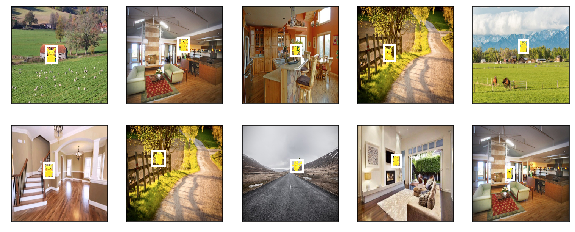

In [19]:
imgs = batch["image"][0:10].permute(0,2,3,1)
bboxes = batch["label"][0:10, 0, 1:]

axes = show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    show_bboxes(ax, [bb*edge_size], colors=['w'])

In [20]:
try:
    !jupyter nbconvert --to python loaddata.ipynb  #ppp是文件的名称
except:
    pass

[NbConvertApp] Converting notebook loaddata.ipynb to python
[NbConvertApp] Writing 7000 bytes to loaddata.py
